Data Focused Python (95-888)  
Final Project  
Hikaru Murase (hikarum), Pranshu Srivastava (pranshus)   
May 7, 2018  

## Part 0 Stracture of this report
This report consists of a data collection part and a data visualization part. To make it easier for graders to grade this report, we briefly described how our repot satisfies the rubric as follows: 

1) Overall Complexity and Scope of Project:  
As we described in the presentation deck, we obtained product information from multiple EC sites by web scraping and web API (in part 1), created and cleand the data tables (in part 1), matched the data for multiple items by using another tool Alteryx (in part 2), and explored the pre-merged and post-merged data to answer a lot of interesting questions (in part 3).

2) Notebooks must be well documented with both Markdown and source code comments:  
In every part, this notebook is well documented with both Markdown and source code comments.

3) Notebooks must be easily readable and executable by the grader. If the grader cannot easily determine a) what needed to be run, b) in what order, or c) receives errors you may receive a 0 for the assignment:  
In every part, we described the instructions so that graders can easily execute the code. We confirmed that all the code run without errors.

4) Appropriate use of descriptive statistics, tabular visualization, cross tabular visualization, and graphical visualization to achieve the scope of your project:  
As we demonstrated in part 3 (and partially in part1), we appropriately used descriptive statisics, tabular visualization, and graphical visualization.

5) Python Language Basics: Demonstrate a command of the concepts we’re learned in the course:  
We demonstrated them throughout the notebook.

6) Built-in Data Structures, Functions, and Files: Demonstrate a command of the concepts we’re learned in the course:  
We demonstrated them (especially Built-in Data Structures) throughout the notebook. (For example, concerning Files, we developed the code to save data frames as a csv file as well as the code to load the xlsx file as Pandas data frame.)

7) Data Loading, Web Scraping, Storage, and File Formats: Demonstrate a command of the concepts we’re learned in the course:  
As indicated in part 1, we conducted web scraping from multiple websites and extracted data using web API (including dealing with JSON data), which is considerablly difficult/compicated tasks.

8) NumPy: Demonstrate a command of the concepts we’re learned in the course:  
We believe that this criterion should be considered combined with the following criteria; what we can do in NumPy can also be done in Pandas (to achieve the scope of our project). Thus, we did use mainly Pandas instead of NumPy. However, to demonstrate our engagement in this course, we used some NumPy technique including Boolean Arrays in part 3.

9) Pandas: Demonstrate a command of the concepts we’re learned in the course:  
As demonstrated in part 1 and in part 3, we stored collected data and handled it as Pandas data frame. We also believe that this criterion should be considered combined with the following two criteria.

10) Data Cleaning and Preparation: Demonstrate a command of the concepts we’re learned in the course:  
As demonstrated in part 1 and part 3, we used Pandas for data cleaning (including sorting, changing names of columns, and dropping NA values).

11) Data Wrangling: Join, Combine, Reshape: Demonstrate a command of the concepts we’re learned in the course:  
As we demonstrated in part 3 (and partially in part 1), we utilized technique of data wrangling (including data join), using Pandas.

12) Plotting & Visualization: Join, Combine, Reshape: Demonstrate a command of the concepts we’re learned in the course:  
As we demonstrated in part 3, we conducted a variety of but meaningful data visualization.

## Part 1 Extracting data
We extracted product data such as product name, price, and customer ratings from eBay, Walmart, and Flipkart. Methods to extract data were web scraping and web API.  
  
We collected product data of "Macbook pro", "Samsung phones", and "Sony digital camera" by changing search queries (search terms). In other words, we extracted item information from search result pages for each search term. Therefore we created nine data tables in total.
  
*Note 1: Amazon does not seem to permit to scrape nor to offer star ratings of each item by API. For this reason, we did not choose Amazon in this project.*  
  
*Note 2: Please run the code in this part from top to bottom. Once you run the code in this part, do not re-run the previous code (otherwise you may come across an error). If you want to re-run the code in this part for some reasons, you will need to start from the beginning of each sub part (i.e. from the beginning of (1), (2), and (3)).*

### (1) Extracting data from eBay by web scraping
We first identified the number of results which was displayed at the top of a search result page. Then, we calculated number of pages so that we could access every result page. (Since 50 items are displayed per page, we can solve for the number of pages by dividing the number of items hit by 50.)  
In each page, we extracted 'list' tags containing star-ratings, title, and price information of a product, and stored them in to a list ('products_table').  
Finally, we converted the list into Pandas data frame of product name, price, and customer ratings obtained ('products_table_df').

In [66]:
import requests
import sys
from bs4 import BeautifulSoup as bs
import time
import math
import pandas as pd

In [67]:
# Cited from lab 3
def get_text_from_elements(elements):
    return [e.text.strip() for e in elements]

In [68]:
search_word = "Samsung phones"
payload = {'_nkw':search_word}
    
r = requests.get('https://www.ebay.com/sch/i.html', params = payload)
page = r.content
soup = bs(page, "html.parser")

# Count the number of pages of the search result
num_items = soup.find_all("span", class_ = "rcnt")
num_items = get_text_from_elements(num_items)
num_items = int(num_items[-1].replace(",","")) # replace "1,234" into "1234" and convert into integer

items_per_page = 50
link_pages = int(math.ceil(num_items / items_per_page))

print("The number of items hit by the search is", num_items)
print("The number of pages is", link_pages)

The number of items hit by the search is 60398
The number of pages is 1208


In [69]:
# Scrape the data from each search result page using for loop (this may take much time)

# Create empty lists
products_table = []

# For each search result page, get all the review rating, title, and price data
for i, page in enumerate(range(min(link_pages, 100))): # to avoid kernel dead, limit maximum pages (100 items * 50 pages)
    page_num = i + 1
    payload = {'_nkw':search_word, '_pgn': page_num}
    r = requests.get('https://www.ebay.com/sch/i.html', params = payload)
    page = r.content
    soup = bs(page, "html.parser")

    # Get product data and store in a list of "products"
    result_items = soup.find_all('div', id = "ResultSetItems")
    r_lists = range(2, items_per_page + 1)
    products = result_items[0].find_all("li", r = "1")
    for r_list in r_lists:
        product = result_items[0].find_all("li", r = str(r_list))[0] # To make class bs4.element.ResultSet into bs4.element.Tag
        products.append(product)

    
    for product in products:
        # Remove products which have not review ratings
        if len(product.find_all("div", class_ = "star-ratings")) != 0:
            # Get review rating data
            review = float(product.find('div', class_ = "star-ratings").find("a")["aria-label"].split(" ")[1])
            # Get title data
            title = product.find('h3', class_ = "lvtitle").find("a").text
            # Get Price data
            price = float(product.find('li', class_ = "lvprice prc").find("span").text.split("$")[-1].replace(",",""))
            # Merge the data
            product_table = [title, review, price]
            # Mutate the data table
            products_table.append(product_table)

            
#print(products_table) # you can print the list by this line
print("The number of obtained products is", len(products_table))

The number of obtained products is 1462


In [70]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in products_table:
    if product[0] not in product_name:
        product_name[product[0]] = 1
    else:
        product_name[product[0]] += 1   
print("The number of unique products is", len(product_name), "out of", len(products_table))

The number of unique products is 1183 out of 1462


In [71]:
# Convert into Pandas Data frame
import pandas as pd
products_table_df = pd.DataFrame(products_table, columns = ["Name", "Ratings", "Price"])
# Print the raw data
products_table_df

,Name,Ratings,Price
0,Samsung Galaxy S5 S4 - Factory Unlocked - GSM ...,4.13,155.99
1,Samsung Galaxy S7 Edge S7 S6 S5 S4 16GB/32GB U...,4.62,359.99
2,New Samsung Galaxy S6 SM-G920T 32GB T-Mobile B...,4.61,213.99
3,Samsung Galaxy S7 edge G935V 32GB Verizon AT&T...,4.62,234.98
4,Samsung Galaxy S7 G930 32GB AT&T T-Mobile 4G L...,4.68,184.99
5,New Samsung Galaxy S6 T-Mobile Unlocked Black ...,4.61,220.00
6,Samsung Galaxy S6 G920P GSM Unlocked Smartphon...,4.63,119.99
7,Samsung G930 Galaxy S7 32GB Android Verizon Wi...,4.65,182.95
8,NEW! SAMSUNG Galaxy J7 SKY PRO 4G LTE 16GB STR...,4.71,115.90
9,Factory Unlocked Samsung Galaxy S7 Edge GSM LT...,4.65,365.99


In [72]:
# Output to CSV file as raw data
products_table_df.to_csv("ebay_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted some special characters including '\r', '\n', and '\t'
- Sorted by product name

In [73]:
# Data Cleaning
# Remove duplicated products
products_table_df2 = products_table_df.drop_duplicates("Name")

# Delele "'\r', '\n', '\t'" from Name column
products_table_df2.loc[:, "Name"] = [name.replace("\t", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("\r", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("\n", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("!!", "") for name in products_table_df2["Name"]]

# Sort by product name and reset index
products_table_df2 = products_table_df2.sort_values(by="Name")
products_table_df2 = products_table_df2.reset_index(drop=True)

C:\Users\hika1\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
# Print the processed data
products_table_df2

,Name,Ratings,Price
0,"""NEW"" Samsung Galaxy MEGA 2 SM-G750A AT&T UNLO...",4.26,165.99
1,"""NEW"" Samsung Galaxy S6 Edge+ Plus SM-G928A 32...",4.58,299.88
2,"""NEW""Samsung Galaxy S7 edge S6 S5 S4 Note 2 3 ...",4.49,399.99
3,"""New"" Samsung Galaxy Note 5 Verizon Wireless U...",4.38,199.95
4,"""New"" Samsung Galaxy S6 Active SM-G890A 32GB G...",4.63,169.95
5,"*NEW OPEN BOX!* SAMSUNG S6 EDGE, BLACK 32GB, V...",4.58,289.00
6,*Samsung Galaxy S4 Smartphone 16GB 32GB White ...,4.57,59.98
7,- NEW- Samsung Gusto 2 Cell Phone Verizon Wirl...,4.50,22.99
8,32GB Samsung Galaxy S6 SM-G920A GSM 4G Unlocke...,4.51,225.99
9,32GB Samsung Galaxy S6 SM-G920V 4G LTE - Black...,4.56,226.99


In [75]:
# Output to CSV file as processed data
products_table_df2.to_csv("ebay_clean.csv")

### (2) Extracting data from Walmart by web API
To diversify methods of acquiring data, we decided to extract Walmart's data using web API. First, we registered Walmart Open API (Product Lookup API), then read the API documents through to understand query parameters and the structure of response. Next, we set query parameters regarding number of items obtained per request (as 25 items) and staring point of each request, then got JSON data for each request. Using for loop, we iterated collecting JSON data 40 times so that we could acquire 1,000 items in total. This is because Walmart Open API offers up to only 1,000 items per keyword. After that, we converted the JSON data into Pandas data frame consisting of product name, price, and customer ratings ('product_table').  
We found that extracting data by web API is relatively easier than by web scraping, although it took several hour to understand how to sign up Walmart Open API and how to use it to obtain product data.

In [76]:
import requests
import pandas as pd

In [77]:
# Determine a search word
search_word = "Samsung phones"

# Create a new list to store product information
product_table = pd.DataFrame()

In [78]:
# Extract data of 1000(=25*40) items (1st-1000th item)
# According to the Walmart API documentation, "Pagination is limited to the top 1000 items for a particular search." 
for i in range(40):
    payload = {'apiKey':'t5f6xrjyupatsqspx28aprtj', 'query':search_word, 'numItems':'25', 'start':str(25*i+1)}
    r = requests.get('http://api.walmartlabs.com/v1/search', params = payload)
    data = r.json()
    items = pd.DataFrame(data["items"], columns=['name', 'salePrice','customerRating'])
    product_table = product_table.append(items, ignore_index = True)
print(len(product_table),"products obtained from total results of", data["totalResults"], "by this code ")

996 products obtained from total results of 425285 by this code 


In [79]:
# Print the raw data
product_table

,name,salePrice,customerRating
0,Straight Talk Samsung Galaxy J3 Luna Pro 16GB ...,59.99,3.905
1,Straight Talk Samsung Galaxy J7 Sky Pro 16GB P...,99.99,4.4
2,AT PREPAID Samsung Galaxy Express Prime 2 16GB...,99.00,4.074
3,Straight Talk Samsung Galaxy J1 Luna 8GB Prepa...,29.99,2.576
4,Cricket Wireless Samsung Galaxy Sol 2 16GB Pre...,99.99,NaN
5,Boost Mobile Samsung J3 Emerge 16GB Prepaid Sm...,79.00,4.288
6,Total Wireless Samsung Galaxy J3 Luna Pro 16GB...,59.00,3.667
7,TracFone Samsung Galaxy J3 Sky 4GB Prepaid Sma...,99.99,4.277
8,Total Wireless Samsung J7 Sky Pro 16GB Prepaid...,149.99,4.5
9,Walmart Family Mobile Samsung Luna Pro Prepaid...,79.99,3.286


In [80]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in product_table['name']:
    if product not in product_name:
        product_name[product] = 1
    else:
        product_name[product] += 1   
print("# of unique products is", len(product_name), "out of", len(product_table['name']))

# of unique products is 762 out of 996


In [81]:
# Output to CSV file as raw data
product_table.to_csv("walmart_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted rows with null data
- Sorted by product name

In [82]:
# Data Cleaning
# Change the column names
product_table.columns = ["Name", "Price", "Ratings"]

# Change the order of the columns
product_table2 = product_table.loc[:,["Name", "Ratings", "Price"]]

# Remove duplicated products
product_table2 = product_table2.drop_duplicates("Name")

# Drop rows containing null data
product_table2 = product_table2.dropna()

# Sort by product name and reset index
product_table2 = product_table2.sort_values(by="Name")
product_table2 = product_table2.reset_index(drop=True)

In [83]:
# Print the processed data
product_table2

,Name,Ratings,Price
0,"""Acuvar 6.5"""" inch Flexible Tripod With Univer...",4.704,5.99
1,"""New Galaxy S6 Edge Plus 32GB G928A by Samsung...",5.0,369.95
2,"""SAMSUNG Convoy 4 - 2.4"""" TFT 512MB - Verizon ...",3.2,99.50
3,"""Value Pack + for 5.5"""" Samsung Galaxy J7 2017...",2.5,11.99
4,"""Value Pack + for 5.5"""" Samsung Galaxy J7 Prim...",5.0,13.75
5,"""Value Pack + for 5.5"""" Samsung Galaxy J7 Prim...",4.0,11.49
6,"""Value Pack + for 6.2"""" Samsung S9 + PLUS Gala...",3.0,11.49
7,"""Value Pack + for 6.2"""" Samsung S9 + PLUS Gala...",3.0,13.49
8,"""Value Pack for 5.5"""" Samsung Galaxy J7 2017 S...",5.0,10.99
9,"""for 5.5"""" Samsung Galaxy J7 2017 sky pro J730...",3.4,8.99


In [84]:
# Output to CSV file as processed data
product_table2.to_csv("walmart_clean.csv")

### (3) Extracting data from Flipkart by web scraping
We first identified the number of result pages which was displayed at the bottom of a search result page. Then, we set queries of page number as well as the search word, and did loop processing to access to all the page of seach results. In each page, we extracted 'div' tags containing star-ratings, title, and price information of a product, and stored them in to a list ('products_table'). One thing that we got confused was that the attribute of the 'div' tags was different among product categories. Thus, it took us some time to examine HTML source whenever we tried to change search keywords. Finally, we converted the list into Pandas data frame of product name, price, and customer ratings obtained ('products_table_df').

In [85]:
import requests
import sys
from bs4 import BeautifulSoup as bs
import time

In [86]:
# Cited from lab 3
def get_text_from_elements(elements):
    return [e.text.strip() for e in elements]

In [87]:
search_word = "Samsung phones"
#payload = {'q':search_word}
payload = {"page": 1, 'q':search_word, 'viewType':'list'}

r = requests.get('http://www.flipkart.com/search', params = payload)
page = r.content
soup = bs(page, "html.parser")

In [88]:
# Count the number of pages of the search result
link_pages = soup.find_all("span", class_ = "_3v8VuN")
link_pages = get_text_from_elements(link_pages)
# To split the string like 'Page 3 of 26' by space, extract a row from the list of one row ('link_pages')
if link_pages == []:
    link_pages = 1
else:
    link_pages = link_pages[0].split(" ")
    link_pages = int(link_pages[-1].replace(",","")) # replace "1,234" into "1234" and convert into integer
print("The number of pages is", link_pages)

The number of pages is 14


In [89]:
# Scrape the data from each search result page using for loop

# Create empty lists
products_table = []

# For each search result page, get all the review rating, title, and price data
for i, page in enumerate(range(min(link_pages, 50))): # to avoid kernel dead, limit maximum pages (40 items * 50 pages)
    page_num = i + 1
    payload = {"page": page_num, 'q':search_word, 'viewType':'list'}
    r = requests.get('http://www.flipkart.com/search', params = payload)
    page = r.content
    soup = bs(page, "html.parser")

    # Get product data (eliminating recently reviewed items and recommended items)
#    products = soup.find_all('div', class_ = "MP_3W3 _31eJXZ") #if you search toys, use this line
    products = soup.find_all('div', class_ = "_1-2Iqu row") # if you search electronics such as laptops, use this line
    for product in products:
        # Remove products which have not review ratings
        if len(product.find_all("div", class_ = "hGSR34 _2beYZw")) != 0:
            # Get review rating data
            review_element = product.find_all("div", class_ = "hGSR34 _2beYZw")
            review_text = review_element[0].text
            review = review_text.split(" ")[0]
            review = float(review)
            # Get title data
#            title = product.find_all("a", class_ = "_2cLu-l")[0].text # if you search toys, use this line
            title = product.find_all("div", class_ = "_3wU53n")[0].text # if you search electronics such as laptops, use this line
            # Get Price data
            price = product.find_all("div", class_ = "_1vC4OE")[0].text
#            price = product.find_all("div", class_ = "_1vC4OE _2rQ-NK")[0].text     
            # Merge the data
            product_table = [title, review, price]
            # Mutate the data table
            products_table.append(product_table)
    
#print(products_table) # You can print the list by this line
print("The number of products is", len(products_table))

The number of products is 311


In [90]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in products_table:
    if product[0] not in product_name:
        product_name[product[0]] = 1
    else:
        product_name[product[0]] += 1   
print("The number of unique products is", len(product_name), "out of", len(products_table))

The number of unique products is 272 out of 311


In [91]:
# Convert into Pandas Data frame
import pandas as pd
products_table_df = pd.DataFrame(products_table, columns = ["Name", "Ratings", "Price"])
# Print the raw table
products_table_df

,Name,Ratings,Price
0,"Samsung Galaxy On Max (Gold, 32 GB)",4.3,"₹13,900"
1,"Samsung Galaxy On Nxt (Gold, 64 GB)",4.2,"₹12,900"
2,"Samsung Galaxy On Max (Black, 32 GB)",4.3,"₹13,900"
3,"Samsung Galaxy On Nxt (Black, 64 GB)",4.2,"₹12,900"
4,"Samsung Galaxy J3 Pro (Gold, 16 GB)",4.2,"₹7,490"
5,"Samsung J7 Max (Black, 32 GB)",4.3,"₹14,900"
6,Samsung Guru Music 2,4.2,"₹1,625"
7,"Samsung J7 Max (Gold, 32 GB)",4.3,"₹14,900"
8,"Samsung Galaxy J7 Nxt (Gold, 16 GB)",4.3,"₹9,490"
9,Samsung Guru Music 2,4.2,"₹1,625"


In [92]:
# Output to CSV file as raw data
products_table_df.to_csv("flipkart_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted Indian Rupee mark from Price
- Sorted by product name

In [93]:
# Data Cleaning
# Remove duplicated products
products_table_df2 = products_table_df.drop_duplicates("Name")

# Eliminate "₹" (Indian Rupee mark from Price) 
products_table_df2.loc[:, "Price"] = [int(price[1:].replace(",", "")) for price in products_table_df2["Price"]]

# Sort by product name and reset index
products_table_df2 = products_table_df2.sort_values(by="Name")
products_table_df2 = products_table_df2.reset_index(drop=True)

C:\Users\hika1\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [94]:
# Print the processed table
products_table_df2

,Name,Ratings,Price
0,Samsung B350,4.0,2580
1,Samsung B351E/Metro 350,4.1,2800
2,Samsung Champ Neo Duos,3.8,3482
3,Samsung E1207 Guru FM Dual Sim - Blue,3.3,1499
4,Samsung E2252,4.1,3023
5,Samsung GT 1200 R/I/M,4.0,1282
6,"Samsung Galaxy A3 (Champagne Gold, 16 GB)",4.0,7800
7,"Samsung Galaxy A3 (Midnight Black, 16 GB)",4.0,7599
8,"Samsung Galaxy A3 (Pearl White, 16 GB)",4.0,8500
9,"Samsung Galaxy A5 (Black, 16 GB)",4.1,15999


In [95]:
# Output to CSV file as processed data
products_table_df2.to_csv("flipkart_clean.csv")

## Part 2 Merging the data
We developed algorithm to merge the data from the three sources. This algorithm was implemented in another tool Alteryx, since it is considerably difficult to merge the data from each EC sites; product names vary in each sites. 

Alteryx is a tool that performs fuzzy matching to find the match between two strings. It checks if the two columns in different data sources have common values or not. To match the strings from two different data sources, we specified the threshold of the match and the algorithm checking what is the probability of two strings being the same. If the probability of two strings being the same is above threshold we specified, it considers the strings as matched (otherwise un-matched). 

There appears to be some incorrect matcheds in the matched data. This is because the Fuzzy algorithm is a probabilistic algorithm. It matches based on probability that the words in one string are same with the words of another string. The two strings in the different data source that is similar may contain some words that are different. Thus, this reduces the probability of matching and the threshold to select matches is reduced. As the cutoff is reduced, it may happen that other unmatched records may spuriously come as matched records. 

Since we tried three kinds of item, "Macbook pro", "Samsung phones", and "Sony digical camera" in part 1, we merged the data from the three data sources for each item. Thus, the output of Alteryx is three csv files (they are on GitHub):
- Matched Records Mackbook Final.csv: contains the common items among the three EC sites when we search "Macbook pro"
- Matched Records Samsung Final.csv: contains the common items among the three EC sites when we search "Samsung phones"
- Matched Records SONY Final.csv: contains the common items among the three EC sites when we search "Sony digital camera"

Also, the algorithm we used in Alteryx is uploaded to GitHub.

## Part 3 Visualizing the data

### (1) Pre-merged data
First, we explored pre-merged data to search for any interesting findigs. We explored the data to answer the questions below: 
- What is the distribution of customer ratings and prices of items sold in each EC sites?
- Are there any relationships between price and customer ratings in EC sites?
  
The outputs of the exploration are as follows.  
  
*Note 1: To run the code below, you need to store the data file ("DataFinal.xlsx") into the same folder as this ipynb file exsits.*  
  
*Note 2: Please run the code in this part from top to bottom. Once you run the code in this part, do not re-run the previous code (otherwise you may come across an error message). If you want to re-run the code in this part for some reasons, you will need to start from here.*

In [31]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
import matplotlib
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

# Read the data file (open excel file)
data_file = pd.ExcelFile('DataFinal.xlsx') 

# Read the three processed data from each csv file and store in each data frame ("Samsung phones")
ebay_data = data_file.parse("ebay_clean_samsung", index_col = 0)
walmart_data = data_file.parse("walmart_clean_samsung", index_col = 0)
flipkart_data = data_file.parse("flipkart_clean_samsung", index_col = 0)

# Read the matched data from the three data sources for each item
matched_record_macbook = data_file.parse('matched_macbook')
matched_record_samsung = data_file.parse('matched_samsung')
matched_record_sony = data_file.parse('matched_sony')

#### (a) Descriptive statistics of item information in EC sites
The descriptive statistics of product ("Samsung phones") data on eBay is as follows. We can see that the mean ratings is 4.56, which is relatively high. Thus, eBay migh offer better customer experience than other two sites.

In [32]:
ebay_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,2269.000000,2269.000000
mean,4.563407,198.231247
std,0.270982,147.758502
min,1.000000,0.010000
25%,4.480000,99.990000
50%,4.570000,169.990000
75%,4.670000,239.950000
max,5.000000,1000.000000


In [33]:
# We used NumPy here to show some statistics.
import numpy as np

print("The mean customer ratings of items sold in eBay is",ebay_data["Ratings"].mean())
print("The number of items which has customer ratings over 4.5 is", (ebay_data["Ratings"] > 4.5).sum(), "out of", ebay_data["Ratings"].count(), "items.")
print("The mean price of items sold in eBay is",ebay_data["Price"].mean(), "US dollars.")
print("The number of items with price over 200 US dollars is", (ebay_data["Price"] > 200).sum(), "out of", ebay_data["Price"].count(), "items.")

The mean customer ratings of items sold in eBay is 4.56340678713089
The number of items which has customer ratings over 4.5 is 1547 out of 2269 items.
The mean price of items sold in eBay is 198.2312472454815 US dollars.
The number of items with price over 200 US dollars is 801 out of 2269 items.


Below is the descriptive statistics of product ("Samsung phones") data on Walmart. Contrary to eBay, Walmart users migit tend to rate items low because the mean ratings is 3.81. However, its standard devieation is much higher than eBay. This implies that Walmart sells both products with very high ratings and products with very low ratings.  
Also, the mean price (in US dollar) of Walmart is lower than that of eBay. This implies that Walmart sells cheaper products than eBay, or many relatively irrelevant cheaper items (such as Samsung phone cases or holders) were just hit by search.

In [34]:
walmart_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,196.000000,196.000000
mean,3.817847,109.628673
std,1.097097,185.376700
min,1.000000,1.790000
25%,3.209000,8.990000
50%,4.000000,16.980000
75%,4.732750,129.990000
max,5.000000,918.740000


In [35]:
print("The mean customer ratings of items sold in Walmart is", walmart_data["Ratings"].mean())
print("The number of items which has customer ratings over 4.5 is", (walmart_data["Ratings"] > 4.5).sum(), "out of", walmart_data["Ratings"].count(), "items.")
print("The mean price is of items sold in Walmart", walmart_data["Price"].mean(), "US dollars.")
print("The number of items with price over 200 US dollars is", (walmart_data["Price"] > 200).sum(), "out of", walmart_data["Price"].count(), "items.")

The mean customer ratings of items sold in Walmart is 3.8178469387755114
The number of items which has customer ratings over 4.5 is 63 out of 196 items.
The mean price is of items sold in Walmart 109.62867346938788 US dollars.
The number of items with price over 200 US dollars is 32 out of 196 items.


The descriptive statistics of product ("Samsung phones") data on Flipkart is as follows. We can see that the mean ratings is 4.08 and the standard deviation is as large as that of eBay. Since 1 (one) US dollar equals to approximately 67 Indian rupees, the mean price is almost the same value as 250 US dollars, which is relatively high. 

In [36]:
flipkart_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,245.000000,245.000000
mean,4.077959,18429.738776
std,0.294352,15424.926670
min,3.000000,1076.000000
25%,4.000000,7490.000000
50%,4.100000,13400.000000
75%,4.200000,25900.000000
max,4.700000,74900.000000


In [37]:
print("The mean customer ratings of items sold in Flipkart is",flipkart_data["Ratings"].mean())
print("The number of items which has customer ratings over 4.5 is", (flipkart_data["Ratings"] > 4.5).sum(), "out of", flipkart_data["Ratings"].count(), "items.")
print("The mean price of items sold in Flipkart is",flipkart_data["Price"].mean(), "Indian rupee.")
print("The number of items with price over 20,000 Indian rupee is", (flipkart_data["Price"] > 20000).sum(), "out of", flipkart_data["Price"].count(), "items.")

The mean customer ratings of items sold in Flipkart is 4.077959183673476
The number of items which has customer ratings over 4.5 is 17 out of 245 items.
The mean price of items sold in Flipkart is 18429.738775510203 Indian rupee.
The number of items with price over 20,000 Indian rupee is 74 out of 245 items.


#### (b) Relationship between price and customer ratings in EC sites
The following plots show the relationship between price and customer ratings of items (searched by "Samsung phones") on eBay. This plot shows that most items are rated high and that there are no expensive items that have lower ratings.  
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on eBay')

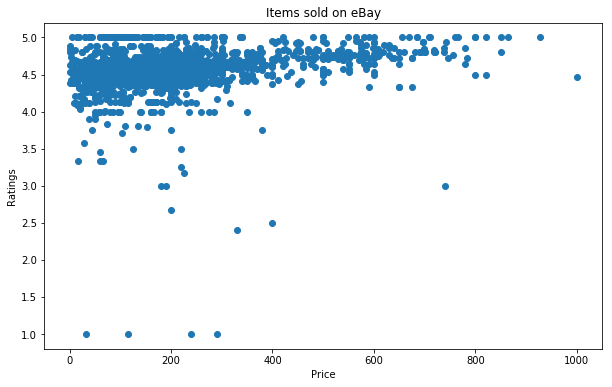

In [38]:
# eBay
plt.plot(ebay_data["Price"], ebay_data["Ratings"], "o") #level-level
#plt.semilogx(ebay_data["Price"], ebay_data["Ratings"], "o") #log-level
#plt.loglog(ebay_data["Price"], ebay_data["Ratings"], "o") #log-log

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on eBay")

The following plot show the relationship between price and customer ratings of items ("Samsung phones") on Walmart. This plot indicates that there might be a weak linear positive relationship between price and ratings. Also, we can say that there are no expensive items that have lower ratings, too.   
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on Walmart')

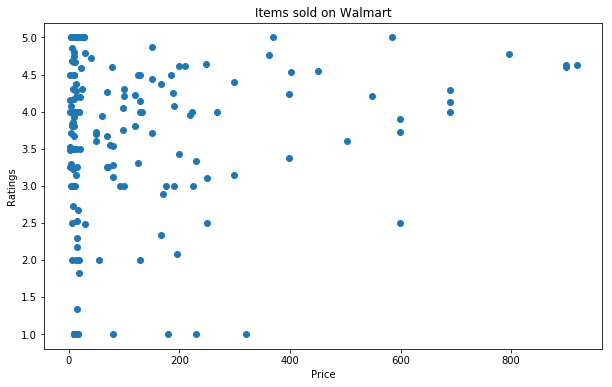

In [39]:
# Walmart
plt.plot(walmart_data["Price"], walmart_data["Ratings"], "o")
#plt.semilogx(walmart_data["Price"], walmart_data["Ratings"], "o")
#plt.loglog(walmart_data["Price"], walmart_data["Ratings"], "o")

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on Walmart")

The following plot show the relationship between price and customer ratings of items ("Samsung phones") on Flipkart. This plot demonstrates that there might be a weak linear positive relationship between price and ratings, but customer ratings appear to be discrete. Also, we can say that there are no expensive items that have lower ratings, too.   
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on Flipkart')

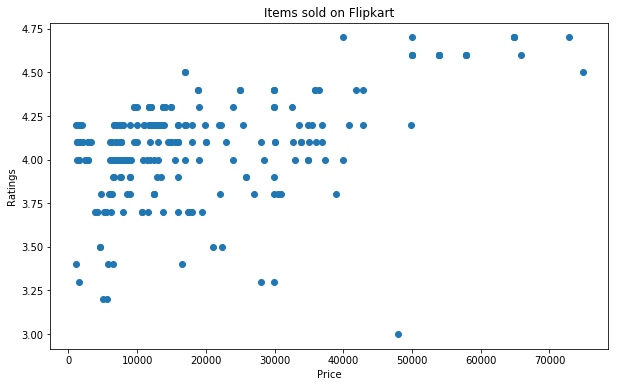

In [40]:
# Flipkart
plt.plot(flipkart_data["Price"], flipkart_data["Ratings"], "o")
#plt.semilogx(flipkart_data["Price"], flipkart_data["Ratings"], "o")
#plt.loglog(flipkart_data["Price"], flipkart_data["Ratings"], "o")

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on Flipkart")

### (2) Matched data
Next, we explored the matched data to answer the questions below:
- Which website has the highest customer ratings of a certain common item among the three EC sites? And how much is it?
- In a certain category (such as "Macbook pro" or "Sony digital camera") rather than for a particular item (such as "Samsung Galaxy A3 (Midnight Black, 16 GB)"), where should we buy to enjoy better customer experience?
- Which website has the most items with the highest customer ratings?
- Which website has the highest and the lowest average price accross markets for a certain category?


#### (a) Match results (our product prototype)
As our product's objective is to compare customer ratings (and price) among the three EC sites for each item, we first created a table to display this information. By demonstrating these tables, we can answer the question: "Which website has the highest customer ratings of a certain common item among the three EC sites? And how much is it?"

In [41]:
## Data cleaning
# Change the column names
column_names = ['Name in eBay', 'Ratings in eBay', 'Price in eBay', 'Source', 'Name in Flipkart',
       'Ratings in Flipkart', 'Price in Flipkart', 'Left_Right_Source',
       'Name in Walmart', 'Ratings in Walmart', 'Price in Walmart', 'Right_Source']
matched_record_macbook_cleaned = matched_record_macbook
matched_record_samsung_cleaned = matched_record_samsung
matched_record_sony_cleaned = matched_record_sony
matched_record_macbook_cleaned.columns = column_names
matched_record_samsung_cleaned.columns = column_names
matched_record_sony_cleaned.columns = column_names

In [42]:
# Display the table of Macbook pro
matched_record_macbook_cleaned[['Name in eBay', 'Ratings in eBay', 'Price in eBay', 'Name in Flipkart','Ratings in Flipkart', 'Price in Flipkart', 'Name in Walmart', 'Ratings in Walmart', 'Price in Walmart']]

,Name in eBay,Ratings in eBay,Price in eBay,Name in Flipkart,Ratings in Flipkart,Price in Flipkart,Name in Walmart,Ratings in Walmart,Price in Walmart
0,Apple MacBook Pro Core i5 2.5GHz 4GB RAM 500GB...,4.76,449.97,Apple Macbook Pro Core i5 - (4 GB/500 GB HDD/O...,4.4,89800,"""Apple MacBook Pro 13.3"""" Intel Dual Core i5 2...",3.462,449.89
1,Apple MacBook Pro Core i5 2.5GHz 4GB RAM 500GB...,4.76,449.97,Apple Macbook Pro Core i5 - (4 GB/500 GB HDD/O...,4.4,89800,"""Certified Refurbished - Apple Macbook Pro 13""...",5.000,769.99
2,Apple MacBook Pro Core i7 2.7GHz 4GB RAM 500GB...,4.88,469.97,Apple Macbook Pro Core i5 - (4 GB/500 GB HDD/O...,4.4,89800,Certified Refurbished - Apple MacBook Pro 15-I...,4.000,544.76
3,"Apple MacBook Pro Retina 15.4"" Intel i7 Quad-C...",4.85,1169.00,Apple MacBook Pro Core i7 5th Gen - (16 GB/256...,4.1,141470,Apple MacBook Pro MJLT2LL/A 15.4-Inch Laptop w...,5.000,2142.89
4,Apple MacBook Pro Retina Display Core i7 2.4GH...,4.84,725.00,Apple MacBook Pro Core i7 5th Gen - (16 GB/256...,4.1,141470,"""Apple MacBook Pro 13.3"""" Intel Dual Core i5 2...",3.462,449.89


In [43]:
# Display the table of Samsung phones
matched_record_samsung_cleaned[['Name in eBay', 'Ratings in eBay', 'Price in eBay', 'Name in Flipkart','Ratings in Flipkart', 'Price in Flipkart', 'Name in Walmart', 'Ratings in Walmart', 'Price in Walmart']]

,Name in eBay,Ratings in eBay,Price in eBay,Name in Flipkart,Ratings in Flipkart,Price in Flipkart,Name in Walmart,Ratings in Walmart,Price in Walmart
0,2 Samsung Galaxy S4 Phones 16GB White Frost Sp...,4.38,140.00,"Samsung Galaxy S4 (White Frost, 16 GB)",3.9,29990,Samsung Galaxy S4 White Certified Pre-Owned (AT),3.100,250.00
1,2 Samsung Galaxy S4 Phones 16GB White Frost Sp...,4.38,140.00,"Samsung Galaxy S4 (White Frost, 16 GB)",3.9,29990,Samsung Galaxy S5 Certified Pre-Owned Smartpho...,4.250,189.00
2,ATT SAMSUNG GALAXY S6 32GB BLACK,4.50,350.00,"Samsung Galaxy S6 (Black Sapphire, 32 GB)",4.1,33900,SAMSUNG GALAXY S7 32GB,1.000,229.99
3,ATT SAMSUNG GALAXY S6 32GB BLACK,4.50,350.00,"Samsung Galaxy S6 (Blue Topaz, 32 GB)",4.1,32750,SAMSUNG GALAXY S7 32GB,1.000,229.99
4,ATT SAMSUNG GALAXY S6 32GB BLACK,4.50,350.00,"Samsung Galaxy S6 (Gold Platinum, 32 GB)",4.1,33900,SAMSUNG GALAXY S7 32GB,1.000,229.99
5,ATT SAMSUNG GALAXY S6 32GB BLACK,4.50,350.00,"Samsung Galaxy S6 Edge (Black Sapphire, 32 GB)",4.0,37299,SAMSUNG GALAXY S7 32GB,1.000,229.99
6,ATT SAMSUNG GALAXY S6 32GB BLACK,4.50,350.00,"Samsung Galaxy S6 Edge (Black, 64 GB)",4.0,39990,SAMSUNG GALAXY S7 32GB,1.000,229.99
7,ATT SAMSUNG GALAXY S6 32GB BLACK,4.50,350.00,"Samsung Galaxy S7 (Black Onyx, 32 GB)",4.4,29990,SAMSUNG GALAXY S7 32GB,1.000,229.99
8,FAIR Condition Samsung Galaxy S7 - 32GB (Veri...,4.65,226.50,"Samsung Galaxy S7 (Gold Platinum, 32 GB)",4.4,29990,SAMSUNG GALAXY S7 32GB,1.000,229.99
9,NEW Samsung Galaxy S7 SM-G930 - 32GB - Black O...,4.66,247.99,"Samsung Galaxy S7 (Black Onyx, 32 GB)",4.4,29990,Samsung Galaxy S7 G930V 32GB Black Onyx Verizo...,3.000,224.92


In [44]:
# Display the table of Sony digital camera
matched_record_sony_cleaned[['Name in eBay', 'Ratings in eBay', 'Price in eBay', 'Name in Flipkart', 'Ratings in Flipkart', 'Price in Flipkart', 'Name in Walmart', 'Ratings in Walmart', 'Price in Walmart']]

,Name in eBay,Ratings in eBay,Price in eBay,Name in Flipkart,Ratings in Flipkart,Price in Flipkart,Name in Walmart,Ratings in Walmart,Price in Walmart
0,Sony Cyber-Shot DSC-RX100 Camera Black,4.83,299.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,DSC-RX100/B Cyber-shot Digital Camera RX100,4.353,448.00
1,Sony Cyber-Shot DSC-RX100 Camera Black,4.83,299.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,Sony Cyber-shot DSC-RX100 Digital Camera (Blac...,4.381,448.00
2,Sony Cyber-Shot DSC-RX100 Camera Black,4.83,299.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,Sony Cyber-shot DSC-RX100 Digital Camera (Blac...,4.381,498.00
3,Sony Cyber-Shot DSC-RX100 Digital Camera,4.83,448.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,DSC-RX100/B Cyber-shot Digital Camera RX100,4.353,448.00
4,Sony Cyber-Shot DSC-RX100 Digital Camera,4.83,448.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,DSC-RX100M3/B Cyber-shot Digital Camera RX100 III,4.406,724.00
5,Sony Cyber-Shot DSC-RX100 Digital Camera,4.83,448.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,DSC-RX100M4 Cyber-shot Digital Camera RX100 IV,4.857,794.98
6,Sony Cyber-Shot DSC-RX100 Digital Camera,4.83,448.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,DSC-RX100M5 RX100 V Cyber-shot Digital Camera,4.591,949.00
7,Sony Cyber-Shot DSC-RX100 Digital Camera,4.83,448.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,DSC-RX10M2 Cyber-shot Digital Camera RX10 II,4.400,1186.99
8,Sony Cyber-Shot DSC-RX100 Digital Camera,4.83,448.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,DSC-RX1R/B Cyber-shot Digital Camera RX1R,4.364,2044.99
9,Sony Cyber-Shot DSC-RX100 Digital Camera,4.83,448.00,Sony DSC-RX100 Point & Shoot Camera,4.7,29897,Sony Cyber-Shot DSC-RX100 Digital Camera + Son...,4.381,458.00


#### (b) Distribution of common product data 
Next, we analyzed a distribution of customer ratings of each item ("Macbook pro", "Samsung phones", and "Sony digital camera") among the three sites.

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

Text(0.5,1,'Distribution of customer ratings for common items in the three EC website')

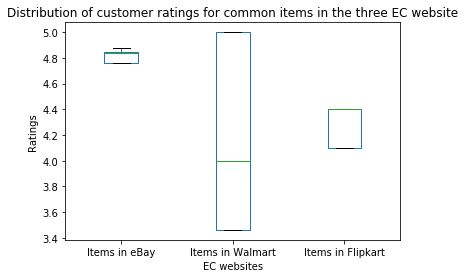

In [46]:
### For Macbook pro ###
# Box ploting
ratings = matched_record_macbook_cleaned[['Ratings in eBay', 'Ratings in Walmart', 'Ratings in Flipkart']]
fig = ratings.plot.box()

# Horizontal box label
fig.set_xticklabels(['Items in eBay', 'Items in Walmart', 'Items in Flipkart'])

# Horizontal label
plt.xlabel('EC websites')

# Vertical label
plt.ylabel('Ratings')

# Title
plt.title('Distribution of customer ratings for common items in the three EC website')

#matched_record_samsung_cleaned
#matched_record_sony_cleaned

According to the box plot above, for "Macbook pro", customer ratings in eBay are generally high. This might indicate eBay offers better customer experience than other sites.   
  
On the other hand, customer ratings in Walmart vary depending on items. Thus, it might be riskier to purchage this kind of item in Walmart.  
  
Besides, customer ratings in Flipkart are generally lower, though the ratings are over 4.0. 

Text(0.5,1,'Distribution of customer ratings for common items in the three EC website')

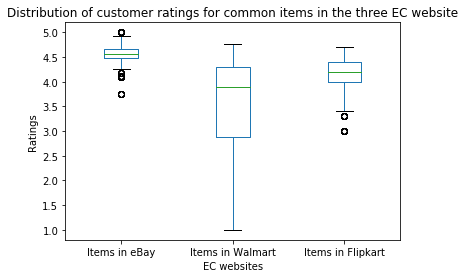

In [47]:
### For Samsung phones ###
# Box ploting
ratings = matched_record_samsung_cleaned[['Ratings in eBay', 'Ratings in Walmart', 'Ratings in Flipkart']]
fig = ratings.plot.box()

# Horizontal box label
fig.set_xticklabels(['Items in eBay', 'Items in Walmart', 'Items in Flipkart'])

# Horizontal label
plt.xlabel('EC websites')

# Vertical label
plt.ylabel('Ratings')

# Title
plt.title('Distribution of customer ratings for common items in the three EC website')

According to the box plot above, for "Samsung phones", customer ratings in eBay are also generally high, although there are some outliers. This might indicate eBay offers better customer experience than other sites.  
  
On the other hand, customer ratings in Walmart vary depending on items, and mean customer ratings is the lowest of the three websites. Thus, Walmart might not offer better customer experience regarding this category.  
  
Customer ratings in Flipkart are moderate.

Text(0.5,1,'Distribution of customer ratings for common items in the three EC website')

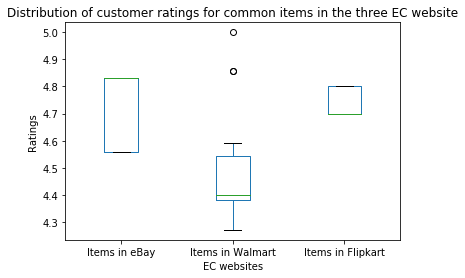

In [48]:
### For Sony digital cameras ###
# Box ploting
ratings = matched_record_sony_cleaned[['Ratings in eBay', 'Ratings in Walmart', 'Ratings in Flipkart']]
fig = ratings.plot.box()

# Horizontal box label
fig.set_xticklabels(['Items in eBay', 'Items in Walmart', 'Items in Flipkart'])

# Horizontal label
plt.xlabel('EC websites')

# Vertical label
plt.ylabel('Ratings')

# Title
plt.title('Distribution of customer ratings for common items in the three EC website')

According to the box plot above, for "Sony digital camera", customer ratings in eBay and in Flipkart are almost equally high. This might indicate these websites offer better customer experience than Walmart.  
  
On the other hand, customer ratings in Walmart are lower, although there are two outliers that have the highest ratings.

#### (c) Market analysis (customer ratings)
Then, we searched for which site has the most items with the highest customer ratings.

In [49]:
# Macbook pro
matched_record_macbook_cleaned["Highest Flag"] = pd.Series(np.zeros(len(matched_record_macbook_cleaned)))
for i in range(len(matched_record_macbook_cleaned)):
    if matched_record_macbook_cleaned.loc[i, 'Ratings in eBay'] >= matched_record_macbook_cleaned.loc[i, 'Ratings in Flipkart']:
        if matched_record_macbook_cleaned.loc[i, 'Ratings in eBay'] >= matched_record_macbook_cleaned.loc[i, 'Ratings in Walmart']:
            matched_record_macbook_cleaned.loc[i, 'Highest Flag'] = "eBay"
        else:
            matched_record_macbook_cleaned.loc[i, 'Highest Flag'] = "Walmart"
    else:
        if matched_record_macbook_cleaned.loc[i, 'Ratings in Flipkart'] >= matched_record_macbook_cleaned.loc[i, 'Ratings in Walmart']:
            matched_record_macbook_cleaned.loc[i, 'Highest Flag'] = "Flipkart"
        else:
            matched_record_macbook_cleaned.loc[i, 'Highest Flag'] = "Walmart"

In [50]:
print(matched_record_macbook_cleaned["Highest Flag"].describe()["freq"],
      "items out of",
      matched_record_macbook_cleaned["Highest Flag"].describe()["count"],
      "items sold in",
      matched_record_macbook_cleaned["Highest Flag"].describe()["top"],
      "have the highest customer ratings of the three EC sites.")

3 items out of 5 items sold in eBay have the highest customer ratings of the three EC sites.


For Macbook pro, more than half of the common items have the highest customer ratings in eBay.

In [51]:
# Samsung phones
matched_record_samsung_cleaned["Highest Flag"] = pd.Series(np.zeros(len(matched_record_samsung_cleaned)))
for i in range(len(matched_record_samsung_cleaned)):
    if matched_record_samsung_cleaned.loc[i, 'Ratings in eBay'] >= matched_record_samsung_cleaned.loc[i, 'Ratings in Flipkart']:
        if matched_record_samsung_cleaned.loc[i, 'Ratings in eBay'] >= matched_record_samsung_cleaned.loc[i, 'Ratings in Walmart']:
            matched_record_samsung_cleaned.loc[i, 'Highest Flag'] = "eBay"
        else:
            matched_record_samsung_cleaned.loc[i, 'Highest Flag'] = "Walmart"
    else:
        if matched_record_samsung_cleaned.loc[i, 'Ratings in Flipkart'] >= matched_record_samsung_cleaned.loc[i, 'Ratings in Walmart']:
            matched_record_samsung_cleaned.loc[i, 'Highest Flag'] = "Flipkart"
        else:
            matched_record_samsung_cleaned.loc[i, 'Highest Flag'] = "Walmart"

In [52]:
print(matched_record_samsung_cleaned["Highest Flag"].describe()["freq"],
      "items out of",
      matched_record_samsung_cleaned["Highest Flag"].describe()["count"],
      "items sold in",
      matched_record_samsung_cleaned["Highest Flag"].describe()["top"],
      "have the highest customer ratings of the three EC sites.")

921 items out of 1110 items sold in eBay have the highest customer ratings of the three EC sites.


For Samsung phones, majority of the common items have the highest customer ratings in eBay.

In [53]:
# Sony digital camera
matched_record_sony_cleaned["Highest Flag"] = pd.Series(np.zeros(len(matched_record_sony_cleaned)))
for i in range(len(matched_record_sony_cleaned)):
    if matched_record_sony_cleaned.loc[i, 'Ratings in eBay'] >= matched_record_sony_cleaned.loc[i, 'Ratings in Flipkart']:
        if matched_record_sony_cleaned.loc[i, 'Ratings in eBay'] >= matched_record_sony_cleaned.loc[i, 'Ratings in Walmart']:
            matched_record_sony_cleaned.loc[i, 'Highest Flag'] = "eBay"
        else:
            matched_record_sony_cleaned.loc[i, 'Highest Flag'] = "Walmart"
    else:
        if matched_record_sony_cleaned.loc[i, 'Ratings in Flipkart'] >= matched_record_sony_cleaned.loc[i, 'Ratings in Walmart']:
            matched_record_sony_cleaned.loc[i, 'Highest Flag'] = "Flipkart"
        else:
            matched_record_sony_cleaned.loc[i, 'Highest Flag'] = "Walmart"

In [54]:
print(matched_record_sony_cleaned["Highest Flag"].describe()["freq"],
      "items out of",
      matched_record_sony_cleaned["Highest Flag"].describe()["count"],
      "items sold in",
      matched_record_sony_cleaned["Highest Flag"].describe()["top"],
      "have the highest customer ratings of the three EC sites.")

12 items out of 22 items sold in eBay have the highest customer ratings of the three EC sites.


For Sony digital cameras, more than half of the common items have the highest customer ratings in eBay.

#### (d) Market analysis (price)
Finally, we have conducted market analysis, comparing the mean price of items among each sites. In this process, we adjusted Indian rupee price in Flipkart to US dollars by dividing the price in Flipkart by 66.62.

In [55]:
# Macbook pro
matched_record_macbook['Price in Flipkart'] = matched_record_macbook['Price in Flipkart'].map(lambda x: x/66.62)
mac_ebay_mean = matched_record_macbook['Price in eBay'].mean()
mac_flipkart_mean = matched_record_macbook['Price in Flipkart'].mean()
mac_walmart_mean = matched_record_macbook['Price in Walmart'].mean()

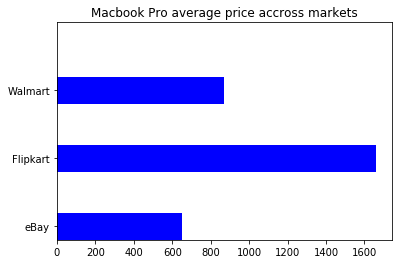

In [56]:
df = pd.DataFrame(dict(graph=['eBay', 'Flipkart', 'Walmart'],price=[mac_ebay_mean, mac_flipkart_mean, mac_walmart_mean])) 
i = np.arange(len(df))
width = 0.4
fig, ax = plt.subplots()
ax.barh(i, df.price, width, color='blue')
ax.set(yticks=i, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
plt.title("Macbook Pro average price accross markets")
plt.show()

In [57]:
# Samsung phones
matched_record_samsung['Price in Flipkart'] = matched_record_samsung['Price in Flipkart'].map(lambda x: x/66.62)
samsung_ebay_mean = matched_record_samsung['Price in eBay'].mean()
samsung_flipkart_mean = matched_record_samsung['Price in Flipkart'].mean()
samsung_walmart_mean = matched_record_samsung['Price in Walmart'].mean()

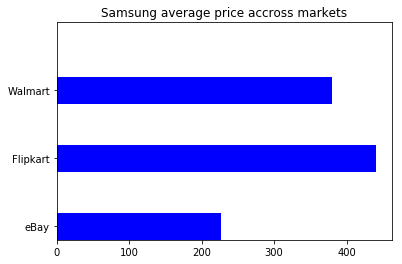

In [58]:
df = pd.DataFrame(dict(graph=['eBay', 'Flipkart', 'Walmart'],price=[samsung_ebay_mean, samsung_flipkart_mean, samsung_walmart_mean])) 
i = np.arange(len(df))
width = 0.4
fig, ax = plt.subplots()
ax.barh(i, df.price, width, color='blue')
ax.set(yticks=i, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
plt.title("Samsung average price accross markets")
plt.show()

In [59]:
# Sony digital camera
matched_record_sony['Price in Flipkart'] = matched_record_sony['Price in Flipkart'].map(lambda x: x/66.62)
sony_ebay_mean = matched_record_sony['Price in eBay'].mean()
sony_flipkart_mean = matched_record_sony['Price in Flipkart'].mean()
sony_walmart_mean = matched_record_sony['Price in Walmart'].mean()

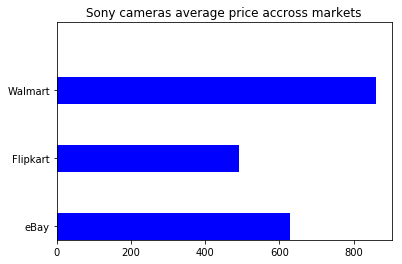

In [60]:
df = pd.DataFrame(dict(graph=['eBay', 'Flipkart', 'Walmart'],price=[sony_ebay_mean, sony_flipkart_mean, sony_walmart_mean])) 
i = np.arange(len(df))
width = 0.4
fig, ax = plt.subplots()
ax.barh(i, df.price, width, color='blue')
ax.set(yticks=i, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
plt.title("Sony cameras average price accross markets")
plt.show()

What we found in the bar-charts above is as follows:
- For "Macbook pro", Flipkart have highest average price and eBay has the lowest.
- For "Samsung phones", Flipkart has highest average price and eBay has the lowest.
- For "Sony digital cameras", Walmart has high average price and Flipkart has the lowest.

### Key findings
Through the comprehensive analyses in this part, we found the following interesting facts:
- When we search "Samsung phones", in average, items sold in eBay tend to have higher customer ratings. This might imply that eBay offers better customer experience regarding this kind of product.
- "Samsung phones" sold in Walmart tend to have lower price than other two EC sites. This might be because relatively more cheaper items which are not actually "Samsung phones" themselves (such as "Samsung phone case covers") are hit in Walmart when searched with the term "Samsung phones."
- It appears that there is almost no expensive item that has lower customer ratings in any EC site for "Samsung phones". (It is possible that there might be a weak linear positive relationship between price and ratings.) People might rate expensive items higher (i.e. Customers tend to be able to enjoy better shopping experience when they buy high-priced items).
- For each common product, you can easily compare customer ratings and price among the EC sites (eBay, Walmart, and Flipkart) by looking at the cleaned matched tables we demonstrated in part (a) of (2) in part 3.
- In general, customer ratings in Walmart vary in a wide range. Those in eBay tend to be slightly higher than those in Flipkart.
- For all the three category ("Macbook pro", "Samsung phones", and "Sony digital camera"), majority of items with the highest customer ratings are sold in eBay. Especially regarding "Samsung phones", most of the items sold in eBay have the highest customer ratings.
- For "Macbook pro" and "Samsung phones", Flipkart have highest average price and eBay has the lowest. For "Sony digital cameras", Walmart has high average price and Flipkart has the lowest.

### References
- Achin Sagar, "Extracting Flipkart reviews through web scraping", Quora, accessed April 8, 2018, https://codeexperiments.quora.com/Extracting-Flipkart-reviews-through-web-scraping
- Search API, "Walmart Open API", https://developer.walmartlabs.com/docs/read/Search_API
- Alteryx, https://www.alteryx.com/